In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle

class SkeletonDataset(Dataset):
    """
    Custom Dataset cho dữ liệu skeleton.
    Đọc dữ liệu từ file .npy và label từ file .pkl,
    sau đó định hình lại cho phù hợp với mô hình RNN/GRU.
    """
    def __init__(self, data_path, label_path):
        # Tải label
        with open(label_path, 'rb') as f:
            self.labels = pickle.load(f)

        # Tải dữ liệu và chuyển sang tensor
        # Dữ liệu gốc có shape (N, C, T, V, M)
        raw_data = np.load(data_path)
        self.data = torch.from_numpy(raw_data).float()

        # Thông tin shape
        self.N, self.C, self.T, self.V, self.M = self.data.shape
        print(f"Loaded data from {data_path} with shape: ({self.N}, {self.C}, {self.T}, {self.V}, {self.M})")


    def __len__(self):
        return self.N

    def __getitem__(self, index):
        # Lấy dữ liệu và label tại index
        sample_data = self.data[index] # Shape: (C, T, V, M)
        label = self.labels[index]

        # Thay đổi shape để phù hợp với GRU
        # Chuyển (C, T, V, M) -> (T, C, V, M)
        sample_data = sample_data.permute(1, 0, 2, 3)

        # Làm phẳng các chiều C, V, M thành một vector đặc trưng duy nhất cho mỗi bước thời gian T
        # Shape sau khi làm phẳng: (T, C * V * M)
        # Ví dụ: (20, 3 * 61 * 1) = (20, 183)
        flattened_data = sample_data.reshape(self.T, -1)

        return flattened_data, torch.tensor(label, dtype=torch.long)

In [10]:
import random
def set_seed(seed_value):
    random.seed(seed_value) # Python's random module
    np.random.seed(seed_value) # NumPy
    torch.manual_seed(seed_value) # PyTorch on CPU
    torch.cuda.manual_seed_all(seed_value) # PyTorch on all GPUs (if available)
    
    # Cấu hình cho thuật toán cuDNN (thường được sử dụng bởi PyTorch trên GPU)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Global seed set to {seed_value}")

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedGRUModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AdvancedGRUModel, self).__init__()

        # --- Lớp GRU ---
        # Keras: GRU(128, return_sequences=True, activation='relu')
        # PyTorch: nn.GRU không hỗ trợ trực tiếp activation='relu'. 
        # Chúng ta sẽ sử dụng nn.GRU tiêu chuẩn và thảo luận về điểm này bên dưới.
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0)

        self.gru2 = nn.GRU(input_size=128, hidden_size=128, batch_first=True)
        self.dropout2 = nn.Dropout(0)

        self.gru3 = nn.GRU(input_size=128, hidden_size=256, batch_first=True)
        self.dropout3 = nn.Dropout(0)
        
        self.gru4 = nn.GRU(input_size=256, hidden_size=512, batch_first=True)
        self.dropout4 = nn.Dropout(0)

        # Lớp GRU cuối cùng, tương đương return_sequences=False
        self.gru5 = nn.GRU(input_size=512, hidden_size=512, batch_first=True)

        # --- Khối Classifier (MLP) ---
        # Sử dụng nn.Sequential để nhóm các lớp Dense lại cho gọn gàng
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(512),       # Tương đương BatchNormalization() sau GRU
            nn.Linear(512, 512),
            nn.ReLU(),                 # Tương đương activation='relu'
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes) # Lớp output, không có softmax (xem giải thích)
        )

    def forward(self, x):
        # Luồng dữ liệu qua các lớp GRU
        # self.gru(x) trả về (output, h_n)
        # output có shape (batch, seq_len, hidden_size)
        # h_n là hidden state cuối cùng
        
        # return_sequences=True
        out, _ = self.gru1(x)
        out = self.dropout1(out)
        
        out, _ = self.gru2(out)
        out = self.dropout2(out)

        out, _ = self.gru3(out)
        out = self.dropout3(out)

        out, _ = self.gru4(out)
        out = self.dropout4(out)

        # Lớp GRU cuối, tương đương return_sequences=False
        out, _ = self.gru5(out)
        
        # Lấy output của bước thời gian cuối cùng
        out = out[:, -1, :] # Shape: (batch, hidden_size)

        # Cho qua khối classifier
        out = self.classifier(out)
        
        return out

In [12]:
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Hàm huấn luyện model trong một epoch."""
    model.train()  # Chuyển model sang chế độ training
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Thống kê
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Hàm đánh giá model trên tập validation hoặc test."""
    model.eval()  # Chuyển model sang chế độ evaluation
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Không cần tính gradient khi đánh giá
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Thống kê
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [13]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward + loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + clip grads
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Step optimizer + scheduler
        optimizer.step()
        scheduler.step()

        # Stats
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [14]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
if __name__ == '__main__':
    # --- 1. Cấu hình & Hyperparameters ---
    DATA_DIR     = '/workspace/data/npy_100'
    NUM_CLASSES  = 2139
    NUM_EPOCHS   = 100
    BATCH_SIZE   = 256
    LEARNING_RATE= 0.001

    set_seed(42)

    # --- 2. Chuẩn bị Dữ liệu ---
    train_dataset = SkeletonDataset(f'{DATA_DIR}/train_data.npy', f'{DATA_DIR}/train_label.pkl')
    val_dataset   = SkeletonDataset(f'{DATA_DIR}/val_data.npy',   f'{DATA_DIR}/val_label.pkl')
    test_dataset  = SkeletonDataset(f'{DATA_DIR}/test_data.npy',  f'{DATA_DIR}/test_label.pkl')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # --- 3. Model, Loss, Optimizer, Scheduler ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = AdvancedGRUModel(input_size=3*61*1, num_classes=NUM_CLASSES).to(device)
    print("--- Model Architecture ---")
    print(model)
    print("--------------------------")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE * 5,
        steps_per_epoch=len(train_loader),
        epochs=NUM_EPOCHS,
        pct_start=0.3,
        div_factor=25.0,
        final_div_factor=1e4
    )

    # --- 4. Training Loop ---
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion,
            optimizer, scheduler, device
        )
        print(f"Train  | Loss: {train_loss:.4f}  Acc: {train_acc:.4f}")

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f"Val    | Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    # --- 5. Final Test ---
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\nTest   | Loss: {test_loss:.4f}  Acc: {test_acc:.4f}")

Global seed set to 42


Loaded data from /workspace/data/npy_100/train_data.npy with shape: (256680, 3, 24, 61, 1)
Loaded data from /workspace/data/npy_100/val_data.npy with shape: (85560, 3, 24, 61, 1)
Loaded data from /workspace/data/npy_100/test_data.npy with shape: (85560, 3, 24, 61, 1)
Using device: cuda
--- Model Architecture ---
AdvancedGRUModel(
  (gru1): GRU(183, 128, batch_first=True)
  (dropout1): Dropout(p=0, inplace=False)
  (gru2): GRU(128, 128, batch_first=True)
  (dropout2): Dropout(p=0, inplace=False)
  (gru3): GRU(128, 256, batch_first=True)
  (dropout3): Dropout(p=0, inplace=False)
  (gru4): GRU(256, 512, batch_first=True)
  (dropout4): Dropout(p=0, inplace=False)
  (gru5): GRU(512, 512, batch_first=True)
  (classifier): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(

Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.60it/s]


Train  | Loss: 5.9434  Acc: 0.0093


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.22it/s]


Val    | Loss: 5.2226  Acc: 0.0136

--- Epoch 2/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.53it/s]


Train  | Loss: 4.4134  Acc: 0.0413


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.98it/s]


Val    | Loss: 3.7339  Acc: 0.0803

--- Epoch 3/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.19it/s]


Train  | Loss: 3.5732  Acc: 0.0912


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.49it/s]


Val    | Loss: 3.4192  Acc: 0.1011

--- Epoch 4/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.54it/s]


Train  | Loss: 3.2323  Acc: 0.1305


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.40it/s]


Val    | Loss: 3.0966  Acc: 0.1455

--- Epoch 5/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 75.70it/s]


Train  | Loss: 2.2677  Acc: 0.3309


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.23it/s]


Val    | Loss: 1.7483  Acc: 0.4546

--- Epoch 6/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.97it/s]


Train  | Loss: 1.1636  Acc: 0.6240


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.11it/s]


Val    | Loss: 1.2146  Acc: 0.6092

--- Epoch 7/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.01it/s]


Train  | Loss: 0.6529  Acc: 0.7894


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.07it/s]


Val    | Loss: 1.3694  Acc: 0.6086

--- Epoch 8/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.28it/s]


Train  | Loss: 0.4628  Acc: 0.8513


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.82it/s]


Val    | Loss: 0.7003  Acc: 0.7855

--- Epoch 9/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.73it/s]


Train  | Loss: 0.3395  Acc: 0.8931


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.67it/s]


Val    | Loss: 0.6080  Acc: 0.8308

--- Epoch 10/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 77.42it/s]


Train  | Loss: 0.2695  Acc: 0.9164


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.29it/s]


Val    | Loss: 0.3446  Acc: 0.8976

--- Epoch 11/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.62it/s]


Train  | Loss: 0.2413  Acc: 0.9261


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.52it/s]


Val    | Loss: 1.2035  Acc: 0.7220

--- Epoch 12/100 ---


Training: 100%|██████████| 1003/1003 [00:14<00:00, 70.89it/s]


Train  | Loss: 0.2124  Acc: 0.9358


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 128.61it/s]


Val    | Loss: 0.2336  Acc: 0.9289

--- Epoch 13/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.98it/s]


Train  | Loss: 0.1931  Acc: 0.9429


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.74it/s]


Val    | Loss: 5.2162  Acc: 0.3642

--- Epoch 14/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 75.10it/s]


Train  | Loss: 0.1875  Acc: 0.9464


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.66it/s]


Val    | Loss: 0.6022  Acc: 0.8430

--- Epoch 15/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.18it/s]


Train  | Loss: 0.1717  Acc: 0.9506


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.22it/s]


Val    | Loss: 1.4657  Acc: 0.6925

--- Epoch 16/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.11it/s]


Train  | Loss: 0.1644  Acc: 0.9537


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.59it/s]


Val    | Loss: 0.1742  Acc: 0.9467

--- Epoch 17/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.57it/s]


Train  | Loss: 0.1621  Acc: 0.9546


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.40it/s]


Val    | Loss: 0.5695  Acc: 0.8561

--- Epoch 18/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.95it/s]


Train  | Loss: 0.1541  Acc: 0.9576


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 121.66it/s]


Val    | Loss: 0.2936  Acc: 0.9218

--- Epoch 19/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.23it/s]


Train  | Loss: 0.1475  Acc: 0.9593


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.82it/s]


Val    | Loss: 0.1726  Acc: 0.9477

--- Epoch 20/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.31it/s]


Train  | Loss: 0.1467  Acc: 0.9602


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 129.44it/s]


Val    | Loss: 3.3899  Acc: 0.5696

--- Epoch 21/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.12it/s]


Train  | Loss: 0.1466  Acc: 0.9614


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 121.92it/s]


Val    | Loss: 0.2003  Acc: 0.9428

--- Epoch 22/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.53it/s]


Train  | Loss: 0.1431  Acc: 0.9621


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.73it/s]


Val    | Loss: 0.1465  Acc: 0.9615

--- Epoch 23/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.36it/s]


Train  | Loss: 0.1500  Acc: 0.9616


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.28it/s]


Val    | Loss: 0.1473  Acc: 0.9608

--- Epoch 24/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.53it/s]


Train  | Loss: 0.1566  Acc: 0.9614


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.53it/s]


Val    | Loss: 0.3974  Acc: 0.9130

--- Epoch 25/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.37it/s]


Train  | Loss: 0.1655  Acc: 0.9602


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 128.09it/s]


Val    | Loss: 0.5107  Acc: 0.8933

--- Epoch 26/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.53it/s]


Train  | Loss: 0.1777  Acc: 0.9590


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 121.93it/s]


Val    | Loss: 0.1972  Acc: 0.9629

--- Epoch 27/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.04it/s]


Train  | Loss: 0.1793  Acc: 0.9596


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.81it/s]


Val    | Loss: 0.6028  Acc: 0.8907

--- Epoch 28/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.96it/s]


Train  | Loss: 0.1911  Acc: 0.9582


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.02it/s]


Val    | Loss: 0.2220  Acc: 0.9511

--- Epoch 29/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 75.25it/s]


Train  | Loss: 0.2033  Acc: 0.9575


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.39it/s]


Val    | Loss: 0.6116  Acc: 0.9017

--- Epoch 30/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.91it/s]


Train  | Loss: 0.2093  Acc: 0.9576


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.11it/s]


Val    | Loss: 0.2291  Acc: 0.9536

--- Epoch 31/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.44it/s]


Train  | Loss: 0.2121  Acc: 0.9587


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.81it/s]


Val    | Loss: 2.2446  Acc: 0.7719

--- Epoch 32/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.96it/s]


Train  | Loss: 0.2191  Acc: 0.9589


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.01it/s]


Val    | Loss: 1.2982  Acc: 0.8578

--- Epoch 33/100 ---


Training: 100%|██████████| 1003/1003 [00:14<00:00, 70.63it/s]


Train  | Loss: 0.2275  Acc: 0.9589


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.54it/s]


Val    | Loss: 0.1406  Acc: 0.9689

--- Epoch 34/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.05it/s]


Train  | Loss: 0.2276  Acc: 0.9600


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.07it/s]


Val    | Loss: 0.9953  Acc: 0.8676

--- Epoch 35/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 72.12it/s]


Train  | Loss: 0.2351  Acc: 0.9612


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.15it/s]


Val    | Loss: 0.3660  Acc: 0.9560

--- Epoch 36/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 73.39it/s]


Train  | Loss: 0.2419  Acc: 0.9620


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.21it/s]


Val    | Loss: 0.5762  Acc: 0.9385

--- Epoch 37/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.35it/s]


Train  | Loss: 0.2510  Acc: 0.9627


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.93it/s]


Val    | Loss: 8.7712  Acc: 0.5019

--- Epoch 38/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.43it/s]


Train  | Loss: 0.2410  Acc: 0.9644


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.42it/s]


Val    | Loss: 1.4715  Acc: 0.8767

--- Epoch 39/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.00it/s]


Train  | Loss: 0.2595  Acc: 0.9643


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.18it/s]


Val    | Loss: 0.7307  Acc: 0.9183

--- Epoch 40/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 77.62it/s]


Train  | Loss: 0.2522  Acc: 0.9658


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.90it/s]


Val    | Loss: 17.2786  Acc: 0.4813

--- Epoch 41/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.40it/s]


Train  | Loss: 0.2657  Acc: 0.9653


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.81it/s]


Val    | Loss: 3.0212  Acc: 0.7772

--- Epoch 42/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.46it/s]


Train  | Loss: 0.2475  Acc: 0.9688


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.32it/s]


Val    | Loss: 0.5107  Acc: 0.9567

--- Epoch 43/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.49it/s]


Train  | Loss: 0.2562  Acc: 0.9693


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.90it/s]


Val    | Loss: 0.4718  Acc: 0.9530

--- Epoch 44/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 77.81it/s]


Train  | Loss: 0.2607  Acc: 0.9706


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 127.37it/s]


Val    | Loss: 9.0459  Acc: 0.6983

--- Epoch 45/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.79it/s]


Train  | Loss: 0.2647  Acc: 0.9707


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.13it/s]


Val    | Loss: 1.7491  Acc: 0.8792

--- Epoch 46/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.43it/s]


Train  | Loss: 0.2780  Acc: 0.9721


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.50it/s]


Val    | Loss: 1.3817  Acc: 0.8922

--- Epoch 47/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.47it/s]


Train  | Loss: 0.2608  Acc: 0.9737


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.93it/s]


Val    | Loss: 1.5233  Acc: 0.9106

--- Epoch 48/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.97it/s]


Train  | Loss: 0.2799  Acc: 0.9744


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.68it/s]


Val    | Loss: 7.3757  Acc: 0.7144

--- Epoch 49/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.94it/s]


Train  | Loss: 0.2773  Acc: 0.9751


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.48it/s]


Val    | Loss: 5.0991  Acc: 0.8204

--- Epoch 50/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.82it/s]


Train  | Loss: 0.2729  Acc: 0.9760


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.51it/s]


Val    | Loss: 1.3779  Acc: 0.9251

--- Epoch 51/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.55it/s]


Train  | Loss: 0.2621  Acc: 0.9772


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 128.19it/s]


Val    | Loss: 2.4415  Acc: 0.8838

--- Epoch 52/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.27it/s]


Train  | Loss: 0.2725  Acc: 0.9788


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.32it/s]


Val    | Loss: 53.2855  Acc: 0.4590

--- Epoch 53/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.75it/s]


Train  | Loss: 0.2475  Acc: 0.9800


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.29it/s]


Val    | Loss: 1.1607  Acc: 0.9330

--- Epoch 54/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.14it/s]


Train  | Loss: 0.2480  Acc: 0.9814


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.95it/s]


Val    | Loss: 1.1183  Acc: 0.9477

--- Epoch 55/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.55it/s]


Train  | Loss: 0.2218  Acc: 0.9823


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.17it/s]


Val    | Loss: 4.7354  Acc: 0.8318

--- Epoch 56/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.37it/s]


Train  | Loss: 0.2286  Acc: 0.9829


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.24it/s]


Val    | Loss: 0.8479  Acc: 0.9509

--- Epoch 57/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.78it/s]


Train  | Loss: 0.2213  Acc: 0.9832


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 121.63it/s]


Val    | Loss: 0.0921  Acc: 0.9872

--- Epoch 58/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.35it/s]


Train  | Loss: 0.1845  Acc: 0.9851


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.35it/s]


Val    | Loss: 0.4074  Acc: 0.9718

--- Epoch 59/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 73.50it/s]


Train  | Loss: 0.1935  Acc: 0.9851


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 128.77it/s]


Val    | Loss: 3.9241  Acc: 0.8747

--- Epoch 60/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 77.97it/s]


Train  | Loss: 0.1844  Acc: 0.9857


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.63it/s]


Val    | Loss: 1.8381  Acc: 0.9315

--- Epoch 61/100 ---


Training: 100%|██████████| 1003/1003 [00:14<00:00, 71.22it/s]


Train  | Loss: 0.1706  Acc: 0.9869


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.37it/s]


Val    | Loss: 0.3914  Acc: 0.9791

--- Epoch 62/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.76it/s]


Train  | Loss: 0.1701  Acc: 0.9877


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.81it/s]


Val    | Loss: 1.0847  Acc: 0.9657

--- Epoch 63/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.07it/s]


Train  | Loss: 0.1452  Acc: 0.9885


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.61it/s]


Val    | Loss: 0.5688  Acc: 0.9742

--- Epoch 64/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.35it/s]


Train  | Loss: 0.1298  Acc: 0.9893


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.86it/s]


Val    | Loss: 0.6508  Acc: 0.9788

--- Epoch 65/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.39it/s]


Train  | Loss: 0.1030  Acc: 0.9908


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.81it/s]


Val    | Loss: 1.7632  Acc: 0.9782

--- Epoch 66/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 77.92it/s]


Train  | Loss: 0.1026  Acc: 0.9913


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.57it/s]


Val    | Loss: 0.4705  Acc: 0.9778

--- Epoch 67/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 73.03it/s]


Train  | Loss: 0.0876  Acc: 0.9918


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.23it/s]


Val    | Loss: 0.1406  Acc: 0.9914

--- Epoch 68/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.69it/s]


Train  | Loss: 0.0835  Acc: 0.9923


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.63it/s]


Val    | Loss: 0.0692  Acc: 0.9919

--- Epoch 69/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 83.26it/s]


Train  | Loss: 0.0803  Acc: 0.9926


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.89it/s]


Val    | Loss: 0.1142  Acc: 0.9899

--- Epoch 70/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.50it/s]


Train  | Loss: 0.0660  Acc: 0.9932


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 129.44it/s]


Val    | Loss: 0.5513  Acc: 0.9842

--- Epoch 71/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.12it/s]


Train  | Loss: 0.0521  Acc: 0.9936


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.15it/s]


Val    | Loss: 0.0498  Acc: 0.9942

--- Epoch 72/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.05it/s]


Train  | Loss: 0.0517  Acc: 0.9940


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.65it/s]


Val    | Loss: 0.2414  Acc: 0.9872

--- Epoch 73/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.71it/s]


Train  | Loss: 0.0494  Acc: 0.9941


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.66it/s]


Val    | Loss: 0.1585  Acc: 0.9920

--- Epoch 74/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.50it/s]


Train  | Loss: 0.0377  Acc: 0.9949


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 121.88it/s]


Val    | Loss: 0.0104  Acc: 0.9964

--- Epoch 75/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.21it/s]


Train  | Loss: 0.0371  Acc: 0.9954


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.54it/s]


Val    | Loss: 0.0955  Acc: 0.9954

--- Epoch 76/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 83.04it/s]


Train  | Loss: 0.0292  Acc: 0.9956


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.30it/s]


Val    | Loss: 0.1384  Acc: 0.9954

--- Epoch 77/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.85it/s]


Train  | Loss: 0.0226  Acc: 0.9958


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.21it/s]


Val    | Loss: 0.3009  Acc: 0.9921

--- Epoch 78/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.82it/s]


Train  | Loss: 0.0308  Acc: 0.9959


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.73it/s]


Val    | Loss: 0.1885  Acc: 0.9966

--- Epoch 79/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 75.86it/s]


Train  | Loss: 0.0172  Acc: 0.9964


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.02it/s]


Val    | Loss: 0.1989  Acc: 0.9961

--- Epoch 80/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 77.54it/s]


Train  | Loss: 0.0154  Acc: 0.9965


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.42it/s]


Val    | Loss: 0.0581  Acc: 0.9965

--- Epoch 81/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.48it/s]


Train  | Loss: 0.0157  Acc: 0.9967


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.88it/s]


Val    | Loss: 0.7141  Acc: 0.9948

--- Epoch 82/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.16it/s]


Train  | Loss: 0.0094  Acc: 0.9972


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.78it/s]


Val    | Loss: 0.0051  Acc: 0.9980

--- Epoch 83/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.78it/s]


Train  | Loss: 0.0094  Acc: 0.9973


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.76it/s]


Val    | Loss: 0.0556  Acc: 0.9969

--- Epoch 84/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.49it/s]


Train  | Loss: 0.0128  Acc: 0.9971


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.64it/s]


Val    | Loss: 0.2670  Acc: 0.9968

--- Epoch 85/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 75.39it/s]


Train  | Loss: 0.0064  Acc: 0.9977


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.10it/s]


Val    | Loss: 0.9214  Acc: 0.9972

--- Epoch 86/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.45it/s]


Train  | Loss: 0.0066  Acc: 0.9977


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.00it/s]


Val    | Loss: 0.6344  Acc: 0.9975

--- Epoch 87/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.23it/s]


Train  | Loss: 0.0043  Acc: 0.9979


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.26it/s]


Val    | Loss: 0.2695  Acc: 0.9978

--- Epoch 88/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.32it/s]


Train  | Loss: 0.0051  Acc: 0.9980


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.93it/s]


Val    | Loss: 0.2524  Acc: 0.9978

--- Epoch 89/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.63it/s]


Train  | Loss: 0.0041  Acc: 0.9983


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.12it/s]


Val    | Loss: 0.0975  Acc: 0.9983

--- Epoch 90/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.05it/s]


Train  | Loss: 0.0039  Acc: 0.9983


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.98it/s]


Val    | Loss: 0.1462  Acc: 0.9980

--- Epoch 91/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.65it/s]


Train  | Loss: 0.0036  Acc: 0.9984


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.61it/s]


Val    | Loss: 0.7977  Acc: 0.9975

--- Epoch 92/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.04it/s]


Train  | Loss: 0.0030  Acc: 0.9985


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.04it/s]


Val    | Loss: 0.1055  Acc: 0.9982

--- Epoch 93/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.35it/s]


Train  | Loss: 0.0027  Acc: 0.9986


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 129.85it/s]


Val    | Loss: 0.0029  Acc: 0.9988

--- Epoch 94/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.74it/s]


Train  | Loss: 0.0026  Acc: 0.9987


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.17it/s]


Val    | Loss: 0.0023  Acc: 0.9989

--- Epoch 95/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.91it/s]


Train  | Loss: 0.0025  Acc: 0.9988


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 125.49it/s]


Val    | Loss: 0.1456  Acc: 0.9986

--- Epoch 96/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.78it/s]


Train  | Loss: 0.0025  Acc: 0.9989


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 123.36it/s]


Val    | Loss: 0.1774  Acc: 0.9987

--- Epoch 97/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.92it/s]


Train  | Loss: 0.0022  Acc: 0.9989


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.36it/s]


Val    | Loss: 0.0798  Acc: 0.9990

--- Epoch 98/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 77.25it/s]


Train  | Loss: 0.0031  Acc: 0.9989


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.59it/s]


Val    | Loss: 0.0743  Acc: 0.9988

--- Epoch 99/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 77.90it/s]


Train  | Loss: 0.0023  Acc: 0.9990


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 126.41it/s]


Val    | Loss: 0.1425  Acc: 0.9988

--- Epoch 100/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 75.38it/s]


Train  | Loss: 0.0025  Acc: 0.9990


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 122.50it/s]


Val    | Loss: 0.1585  Acc: 0.9987


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.69it/s]


Test   | Loss: 0.1751  Acc: 0.9986


In [ ]:
import matplotlib.pyplot as plt

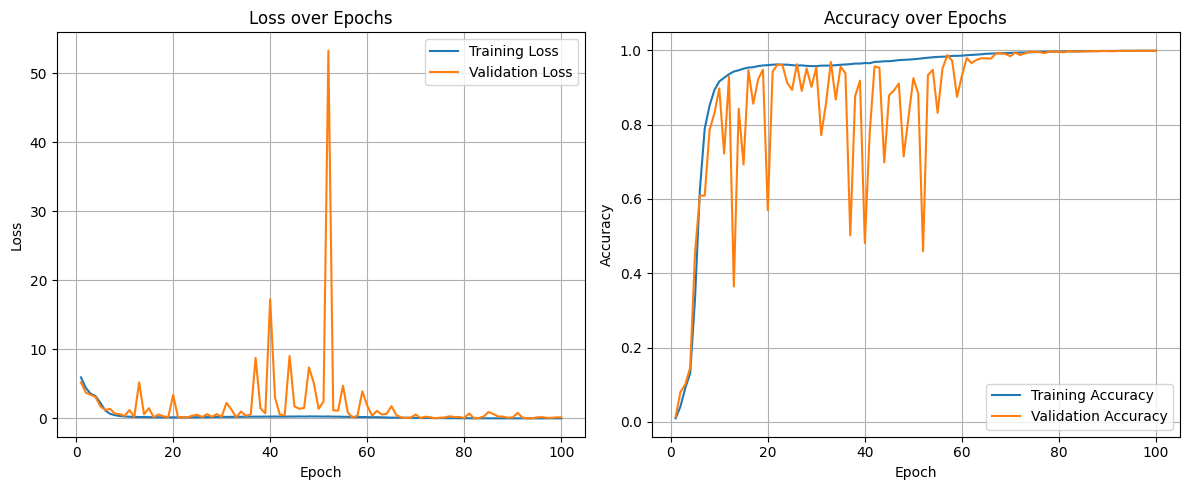

Plots generated successfully!


In [ ]:
epochs_range = range(1, NUM_EPOCHS + 1) 
plt.figure(figsize=(12, 5)) # Tạo một hình vẽ mới với kích thước 12x5 inches
plt.subplot(1, 2, 1) # Tạo biểu đồ con thứ nhất (1 hàng, 2 cột)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2) # Tạo biểu đồ con thứ hai (1 hàng, 2 cột)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các biểu đồ con để tránh chồng chéo
plt.show() # Hiển thị các biểu đồ
print("Plots generated successfully!")

In [ ]:
# if __name__ == '__main__':
#     # --- 1. Cấu hình & Hyperparameters ---
#     DATA_DIR = '/workspace/data/npy_100'  # THAY ĐỔI ĐƯỜNG DẪN NÀY
#     NUM_CLASSES = 2139                         # THAY ĐỔI số lượng lớp (class) nếu cần
#     set_seed(42)  # Đặt seed toàn cục để đảm bảo tính tái lập
#     # Model Hyperparameters
#     # Với AdvancedGRUModel, các giá trị hidden_size và num_layers đã được định nghĩa
#     # cứng bên trong kiến trúc model, nên chúng ta không cần truyền vào nữa.
#     INPUT_SIZE = 3 * 61 * 1  # C * V * M
    
#     # Training Hyperparameters
#     NUM_EPOCHS = 200
#     BATCH_SIZE = 256
#     LEARNING_RATE = 0.001

#     # --- 2. Chuẩn bị Dữ liệu ---
#     # Tạo Datasets (phần này giữ nguyên)
#     train_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/train_data.npy',
#         label_path=f'{DATA_DIR}/train_label.pkl'
#     )
#     val_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/val_data.npy',
#         label_path=f'{DATA_DIR}/val_label.pkl'
#     )
#     test_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/test_data.npy',
#         label_path=f'{DATA_DIR}/test_label.pkl'
#     )

#     # Tạo DataLoaders (phần này giữ nguyên)
#     train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#     val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#     test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#     # --- 3. Khởi tạo Model, Loss, Optimizer ---
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")

#     # **THAY ĐỔI CHÍNH Ở ĐÂY**
#     # Khởi tạo model AdvancedGRUModel với các tham số cần thiết
#     model = AdvancedGRUModel(input_size=INPUT_SIZE, num_classes=NUM_CLASSES).to(device)
#     print("--- Model Architecture ---")
#     print(model)
#     print("--------------------------")

#     # Hàm mất mát và trình tối ưu hóa (giữ nguyên)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
#     train_losses = []
#     val_losses = []
#     train_accuracies = []
#     val_accuracies = []
    
#     # --- 4. Vòng lặp Huấn luyện --- (giữ nguyên)
#     for epoch in range(NUM_EPOCHS):
#         print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
#         train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
#         print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

#         val_loss, val_acc = evaluate(model, val_loader, criterion, device)
#         print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         train_accuracies.append(train_acc)
#         val_accuracies.append(val_acc)

#     print("\n--- Training Finished ---")

#     # --- 5. Đánh giá cuối cùng trên tập Test --- (giữ nguyên)
#     test_loss, test_acc = evaluate(model, test_loader, criterion, device)
#     print(f"\nFinal Test Results | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

#     # (Tùy chọn) Lưu model
#     # torch.save(model.state_dict(), 'advanced_gru_model.pth')
#     # print("Model saved to advanced_gru_model.pth")